<a href="https://colab.research.google.com/github/sanghamitra23/python_basic/blob/master/Quora_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c quora-insincere-questions-classification

In [0]:
!unzip train.csv.zip
!unzip test.csv.zip
!unzip embeddings.zip

In [0]:
import pandas as pd
import numpy as np
import re
# cross validation and metrics
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import *

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

import datetime
from string import punctuation
import warnings
warnings.filterwarnings("ignore")

In [0]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, '')
    return x


def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [74]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

train = add_features(train_df)
test = add_features(test_df)

# lower
train_df["question_text"] = train_df["question_text"].apply(lambda x: x.lower())
test_df["question_text"] = test_df["question_text"].apply(lambda x: x.lower())

# Clean the text
train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))

# Clean numbers
train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_numbers(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_numbers(x))

# Clean speelings
train_df["question_text"] = train_df["question_text"].apply(lambda x: replace_typical_misspell(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: replace_typical_misspell(x))

## fill up the missing values
train_X = train_df["question_text"].fillna("_##_").values
test_X = test_df["question_text"].fillna("_##_").values

## Get the target values
train_y = train_df['target'].values

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [75]:
train_df['question_length'] = train.question_text.apply(lambda x: len(x))
print('The max length of question is:',train_df.question_length.max())
print('The minimum length of question is:',train_df.question_length.min())
print('The mean length of question is:',train_df.question_length.mean())
print('The max standard deviation of question is:',train_df.question_length.std())

The max length of question is: 716
The minimum length of question is: 0
The mean length of question is: 68.8979444492934
The max standard deviation of question is: 37.91917980851609


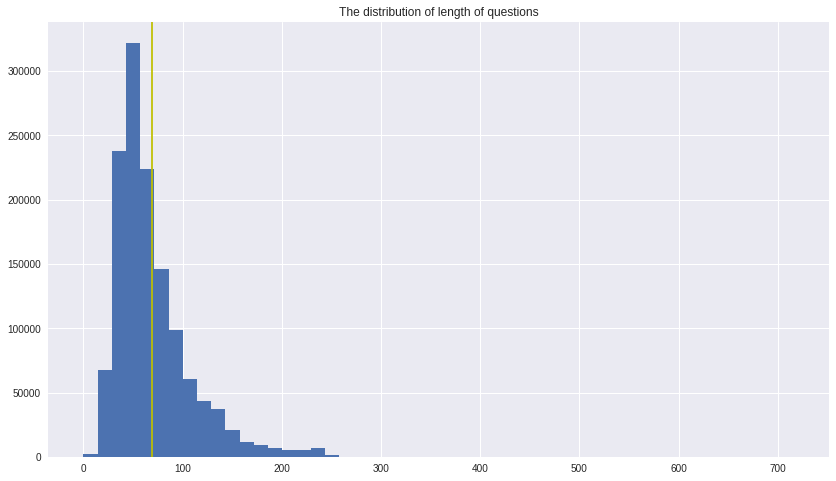

In [76]:
train_df.question_length.hist(bins=50)
plt.title('The distribution of length of questions')
plt.axvline(np.mean(train_df.question_length),color='y')

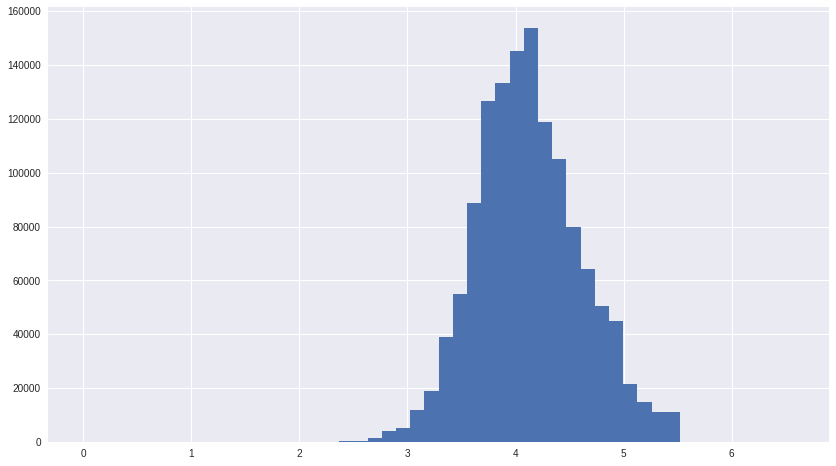

In [77]:
train_df['question_length_scaled'] = train_df.question_length.apply(lambda x: np.log(x+1))
train_df.question_length_scaled.hist(bins=50)

Text(0.5, 1.0, 'The distribution of length of target or not')

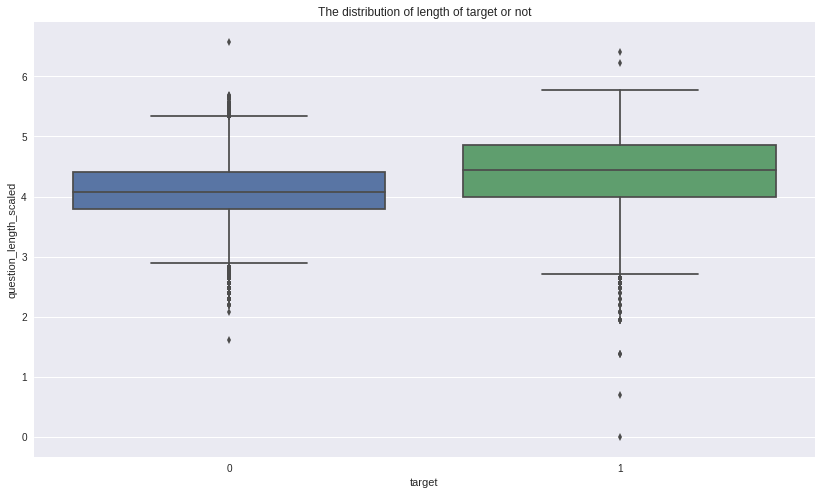

In [78]:
sns.boxplot(train_df.target,train_df.question_length_scaled)
plt.title('The distribution of length of target or not')

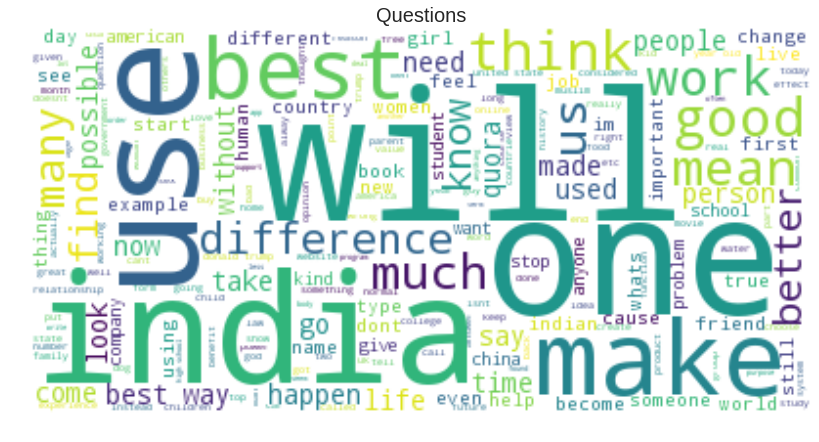

In [79]:
np.random.seed(321)
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(train_df['question_text'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Questions',size=20)
plt.show()

In [0]:
train_1 = train_df[train_df.target == 1]
train_0 = train_df[train_df.target == 0]

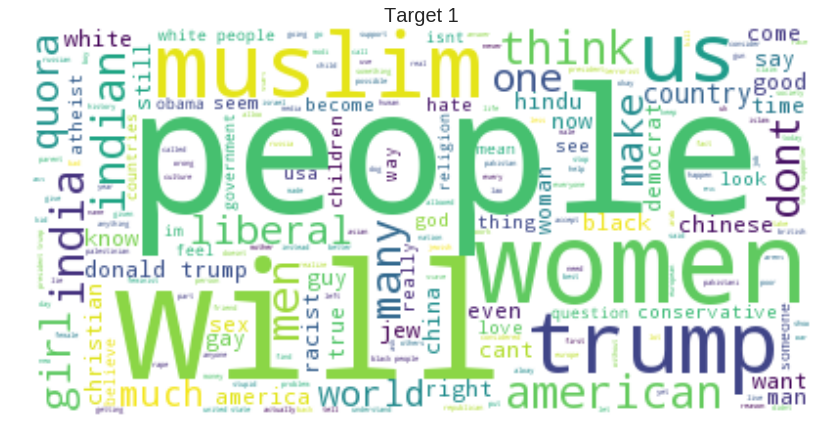

In [86]:
reviews = ' '.join(train_1['question_text'].tolist())
wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Target 1',size=20)
plt.show()

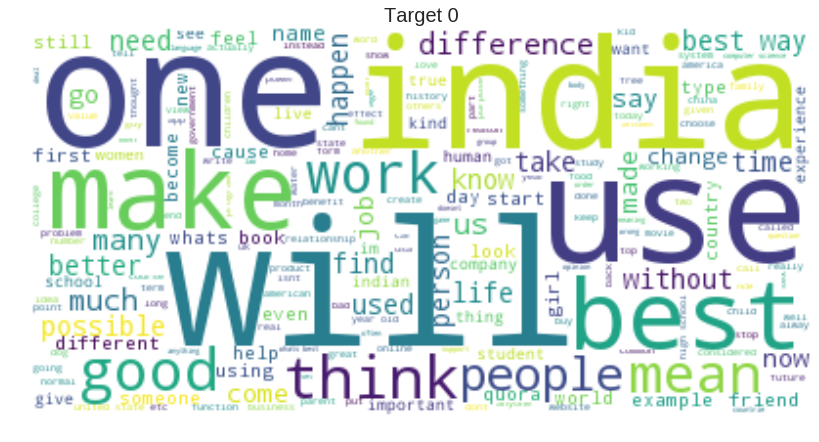

In [87]:
reviews = ' '.join(train_0['question_text'].tolist())
wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Target 0',size=20)
plt.show()

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

prec = Pipeline([('vect', CountVectorizer(min_df=5, max_features=5000, ngram_range=(1,3),
                        strip_accents='unicode',
                        lowercase =True, analyzer='word', token_pattern=r'\w+',
                        stop_words = 'english')),
               ('tfidf', TfidfTransformer()),
              ])
df_tf_idf = prec.fit_transform(train_X)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_tf_idf, train_y, test_size=0.25, random_state=1000)

In [83]:
%%time
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('F1 Score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy 0.9420881937702699
F1 Score 0.33420181677346666
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    306314
           1       0.58      0.23      0.33     20217

   micro avg       0.94      0.94      0.94    326531
   macro avg       0.77      0.61      0.65    326531
weighted avg       0.93      0.94      0.93    326531

CPU times: user 602 ms, sys: 11 ms, total: 613 ms
Wall time: 619 ms


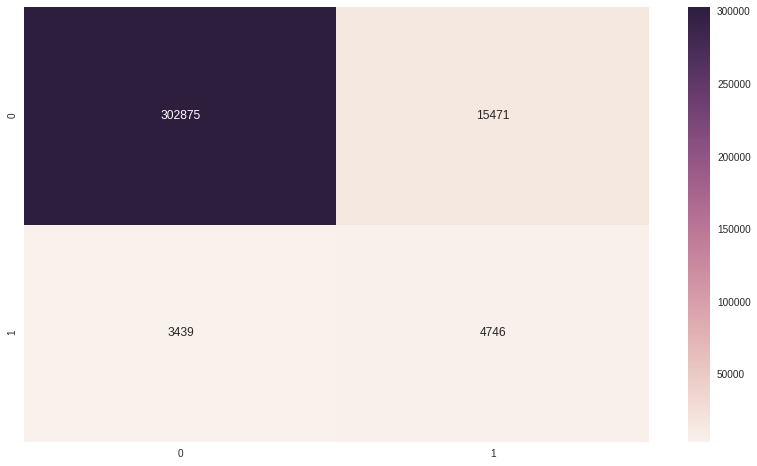

In [81]:
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt='2.0f')

In [0]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('F1 Score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt='2.0f')